# PINN - Heat Equation

## Theory
### Heat Equation in 1D
The simpliest case of a heat equation is given by:
$$u_t = \alpha u_{xx}$$
for some function $u(x,t)$ and some diffusive coefficent $\alpha$

### Separation of Variable
Then, typically, we solve by assuming a separable solution and take the ansatz that $u(x,t) = X(x)T(t)$ and so, the differential equation becomes:
$$ XT'= \alpha X''T $$
We then rearrange and set it to some separation constant $k$
$$\frac{X''}{X}= \frac{1}{\alpha}\frac{T'}{T}=-k^2$$
and so, this allows us to split into 2 ODE. 

Firsly, we consider the space ODE:
$$X'' = -k^2 X$$
which of course we can recognise as a simple harmonic oscillator in x and has solution:
$$X(x) = A\cos(kx)+B\sin(kx)$$
As for the time ODE:
$$T' = -\alpha k^2 T$$
which has exponential solution of:
$$T(t) = Ce^{-\alpha k^2 t}$$

### Boundary Condition 
We demand the u(0) = u(L,0) for width L of the rod and so:
$$X(0) = 0 \implies A = 0$$
$$X(L) = B\sin(kL) = 0 \implies k = \frac{n\pi}{L}$$
for $n \in \mathbb N$
### Most General Solution
Following from which,
$$u_n(x,t) = D_n\sin(\frac{n\pi}{L})e^{-\alpha(\frac{n\pi}{L})^2 t}$$
for some coefficient to be determined D.

Hence, the most general solution is a linear combination of all n:
$$u(x,t) = \sum^{\infty}_{n = 0}D_n\sin(\frac{n\pi}{L})e^{-\alpha(\frac{n\pi}{L})^2 t}$$
and by taking the inner product, we see:
$$D_n = \frac{2}{L}\int^{L}_{0} f(x) \sin(\frac{n\pi}{L}) dx $$
where $u(x)$ equals to some source term $f(x)$
## Goal
Our goal is then, to create a PINN programme such that it can "discover" the solution as it trains. Therefore, let's start!

# Heat Equation Solver
## Importing Libraries
Let's import some libraries that we are going to use in this project:

In [2]:
#%matplotlib ipympl
#For interactive plots
%matplotlib inline
#For inline plots

from PIL import Image #For our image saving/writing (https://pillow.readthedocs.io/en/stable/reference/Image.html)

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.integrate 

## Fully Connected Network
Now, we define our FCN, some helper function, and our analytical solution (we want to get training data from it!)

In [115]:
def heateq(x, f, nmax=50, L=1, alpha=1):
    "Analytical solution to the 1D Heat Equation"
    # convert x and t to numpy for SciPy compatibility
    x_np = x.detach().cpu().numpy().flatten()

    # compute Fourier coefficients D_n
    D_n = []
    for n in range(1, nmax + 1):
        integrand = lambda xx: f(xx) * np.sin(n * np.pi * xx / L)
        Dn, _ = quad(integrand, 0, L)
        Dn *= 2 / L
        D_n.append(Dn)

    # reconstruct u(x,t)
    u = np.zeros_like(x_np)
    for n, Dn in enumerate(D_n, start=1):
        u += Dn * np.sin(n * np.pi * x_np / L)

    return torch.tensor(u, dtype=torch.float32).view(-1, 1)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh #We have chosen the activation function to be tanh()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x) #Input Layers 
        x = self.fch(x) #Hidden layers
        x = self.fce(x) #Ending/Outout Layers
        return x

## Analytical Solution
Before we dive into the fun world of PINN, let's just see how the analytical solution for fixed time t = 0 look!

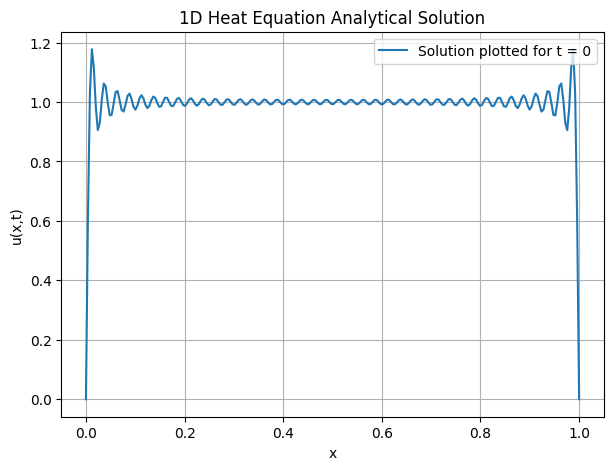

In [151]:
#Define Parameters 
L = 1
alpha = 0.1
nmax = 80
nx = 250
nt = 250
x = torch.linspace(0, L, nx).view(-1, 1)

# --- Initial Condition ---
def f(x):
    return 1

u = heateq(x, f, nmax, L, alpha).view(-1,1)

plt.figure(figsize=(7, 5))
plt.plot(x.numpy(), u.numpy(), label="Solution plotted for t = 0")    
plt.title("1D Heat Equation Analytical Solution")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

## Physics-Informed Loss Functions
Now we get to the fun part of training the model! What's special about PINN is the fact we encode known physics into the loss function, such as the residue comimg from the differential equation:
$$ \mathcal{L} = \lambda \sum^{n}_{i} |\alpha u_{xx}-u_t|^2$$
where we want to minimise the residue above for some weight $\lambda$

Of course, we can also do compare the training points to the data point for the another component loss function as well (as is the common case in typical Neural Network):
$$\mathcal{L} = \lambda \sum^{n}_{i} |u_{PINN}-u_{data}|^2$$

Training PINN:   0%|                                                       | 0/5000 [00:00<?, ?it/s]


Epoch    1 | Data: 1.00e+00 | BC: 1.31e-03 | DE: 1.86e-06 | Total: 1.00e+00


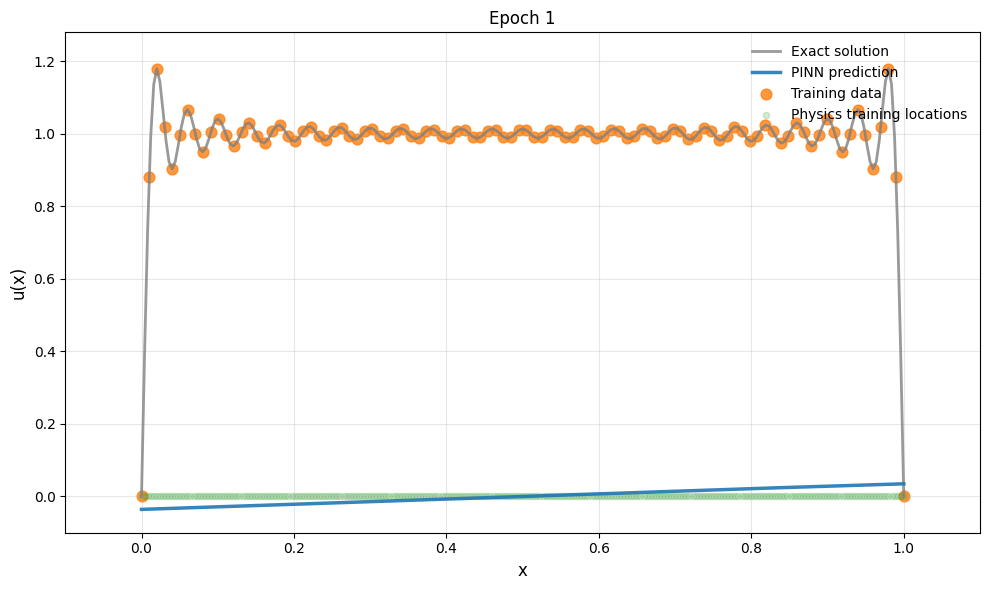

Training PINN:  10%|████▏                                       | 478/5000 [00:01<00:11, 396.37it/s]


Epoch  500 | Data: 1.23e-01 | BC: 8.37e-02 | DE: 3.33e-01 | Total: 2.07e-01


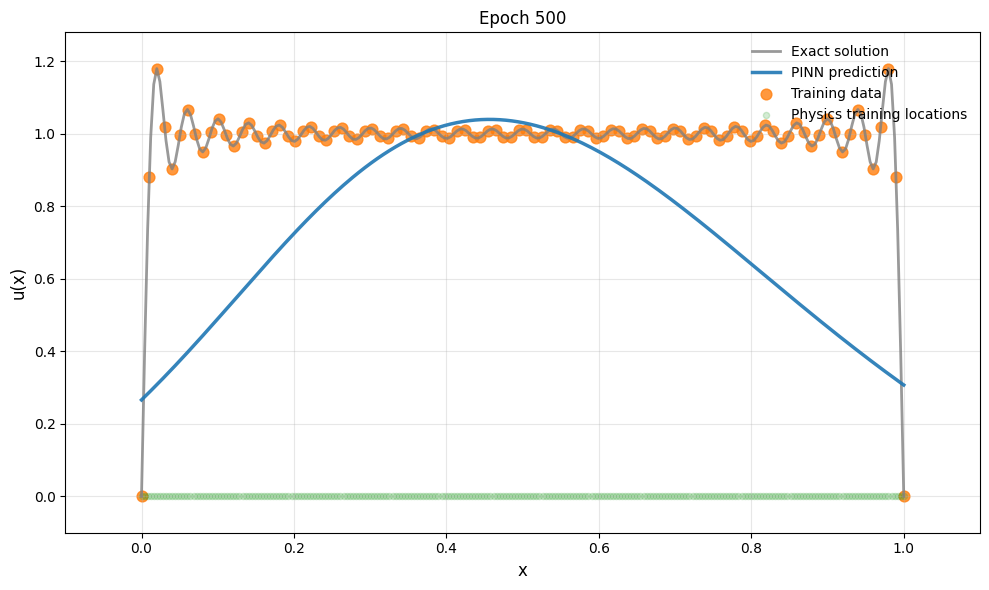

Training PINN:  19%|████████▌                                   | 967/5000 [00:02<00:10, 398.39it/s]


Epoch 1000 | Data: 1.13e-01 | BC: 1.94e-02 | DE: 9.16e-01 | Total: 1.32e-01


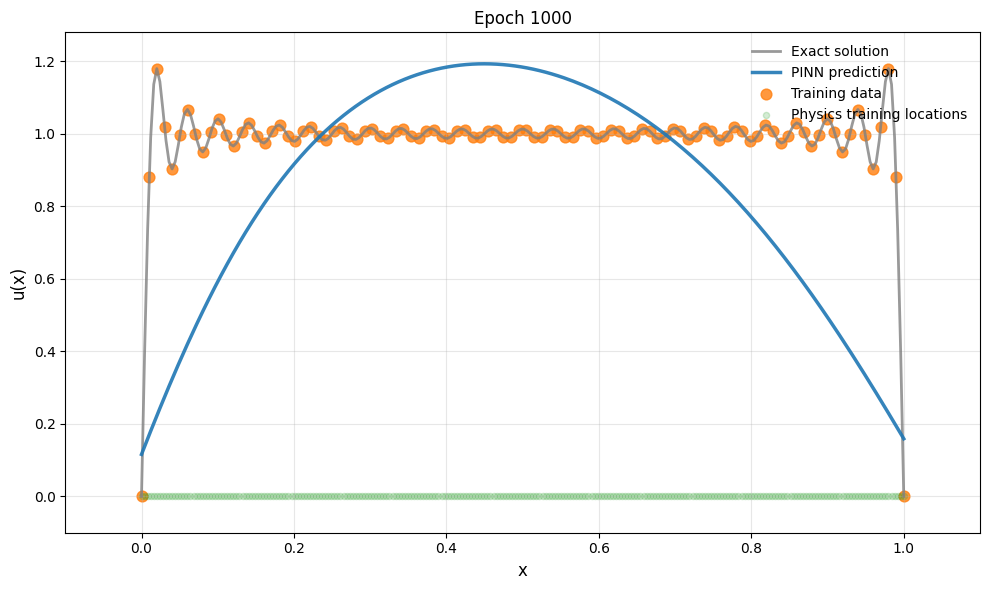

Training PINN:  30%|████████████▉                              | 1498/5000 [00:04<00:08, 391.44it/s]


Epoch 1500 | Data: 7.44e-02 | BC: 8.17e-03 | DE: 4.73e+00 | Total: 8.26e-02


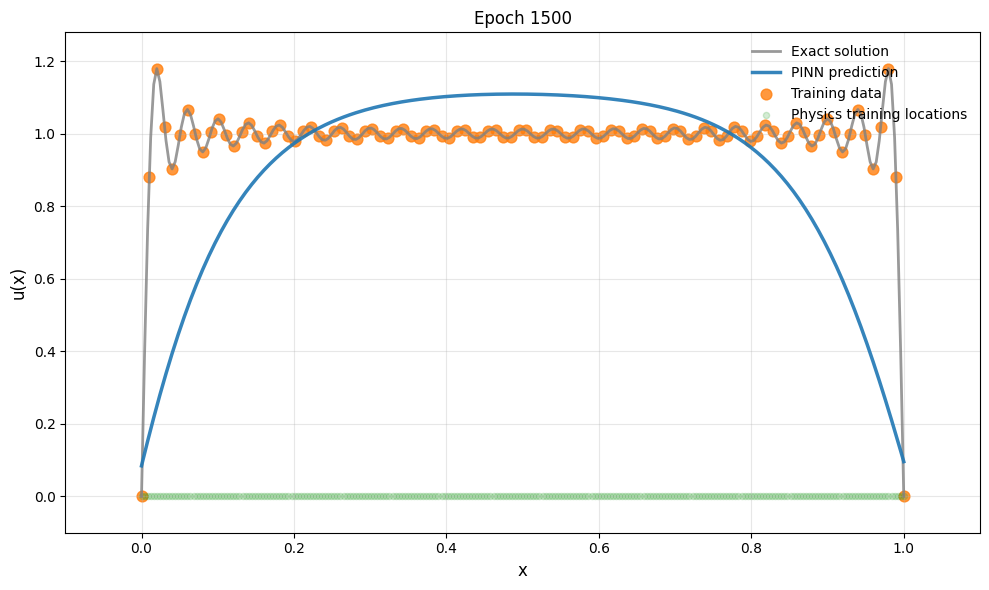

Training PINN:  40%|█████████████████                          | 1977/5000 [00:05<00:07, 399.38it/s]


Epoch 2000 | Data: 3.33e-02 | BC: 1.61e-03 | DE: 5.28e+01 | Total: 3.49e-02


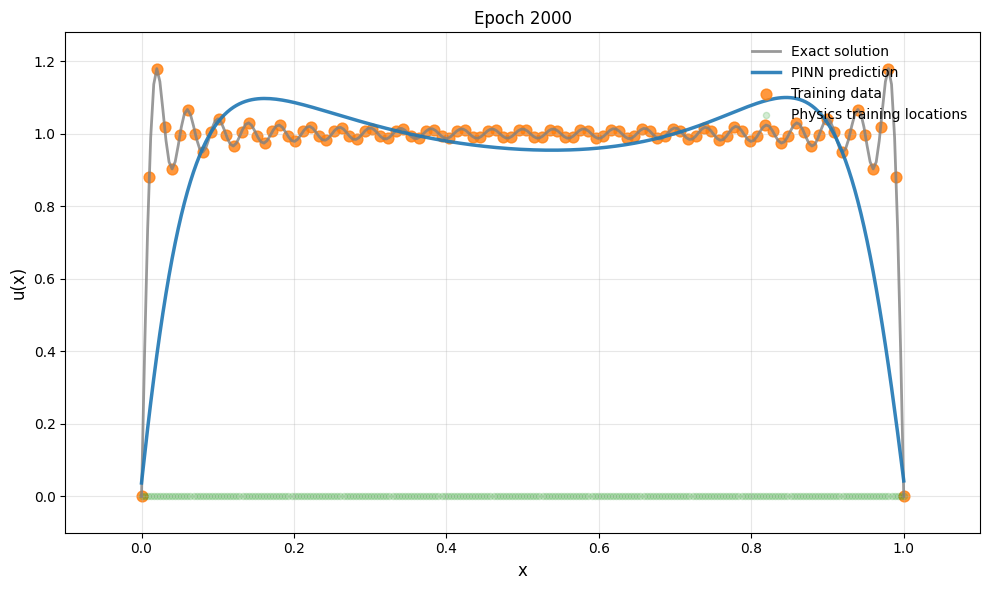

Training PINN:  49%|█████████████████████▏                     | 2467/5000 [00:07<00:06, 393.28it/s]


Epoch 2500 | Data: 2.06e-02 | BC: 3.90e-04 | DE: 1.96e+02 | Total: 2.10e-02


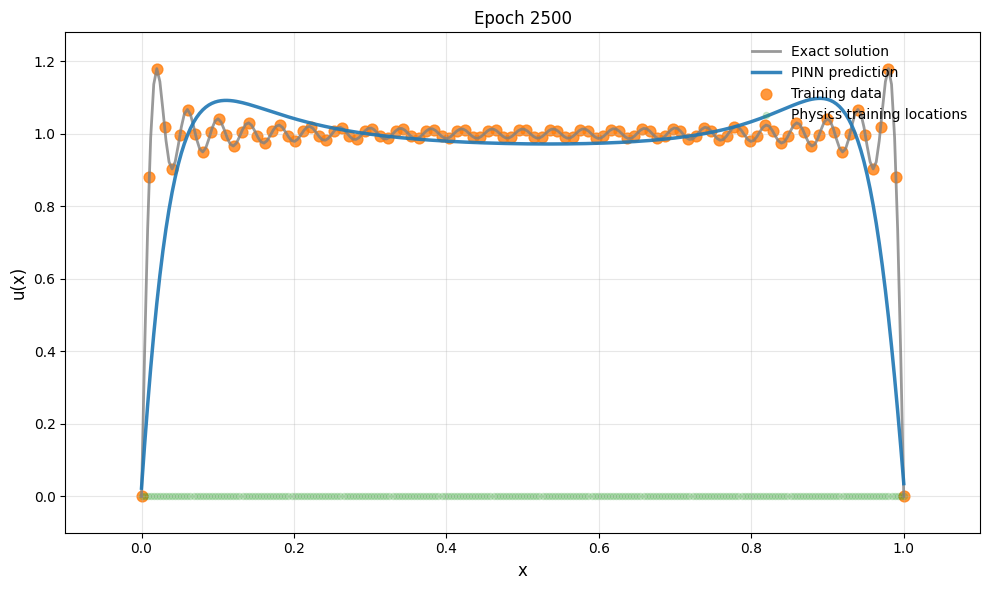

Training PINN:  60%|█████████████████████████▋                 | 2985/5000 [00:08<00:05, 363.32it/s]


Epoch 3000 | Data: 1.27e-02 | BC: 1.86e-04 | DE: 5.26e+02 | Total: 1.29e-02


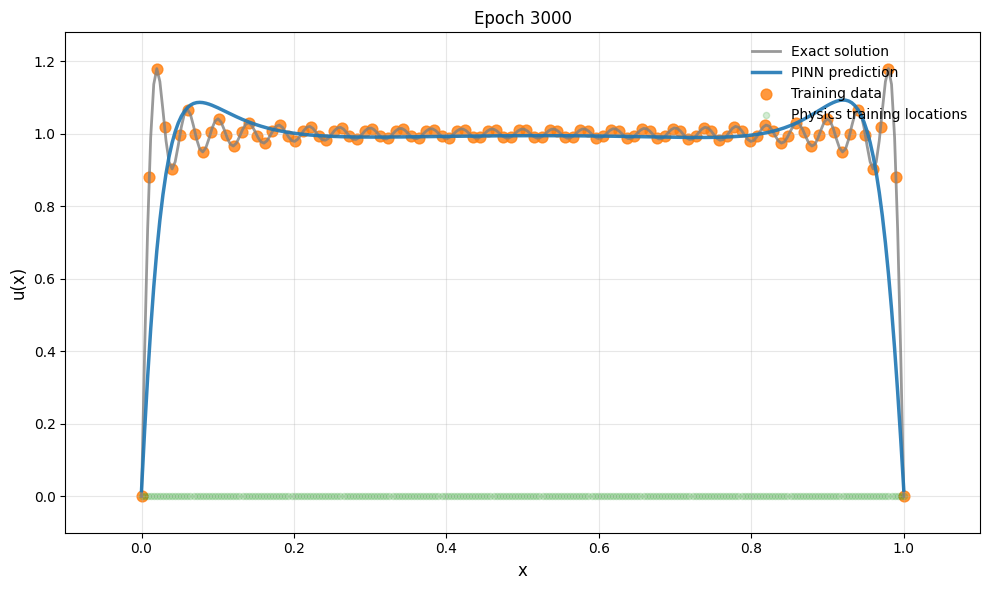

Training PINN:  70%|██████████████████████████████             | 3497/5000 [00:10<00:03, 391.74it/s]


Epoch 3500 | Data: 8.41e-03 | BC: 1.09e-04 | DE: 1.10e+03 | Total: 8.52e-03


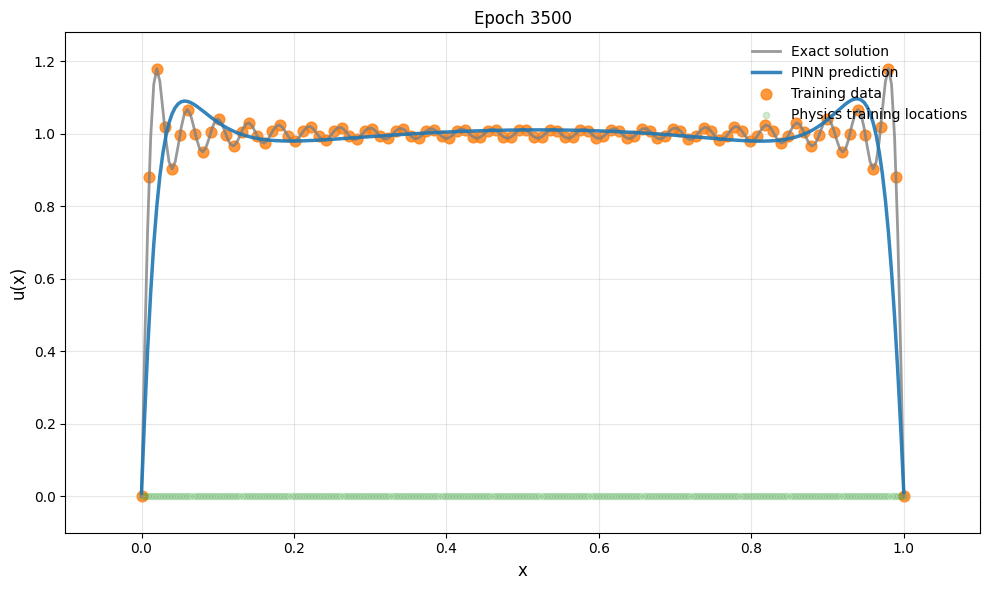

Training PINN:  79%|██████████████████████████████████▏        | 3972/5000 [00:11<00:02, 388.10it/s]


Epoch 4000 | Data: 5.96e-03 | BC: 3.87e-05 | DE: 1.93e+03 | Total: 6.00e-03


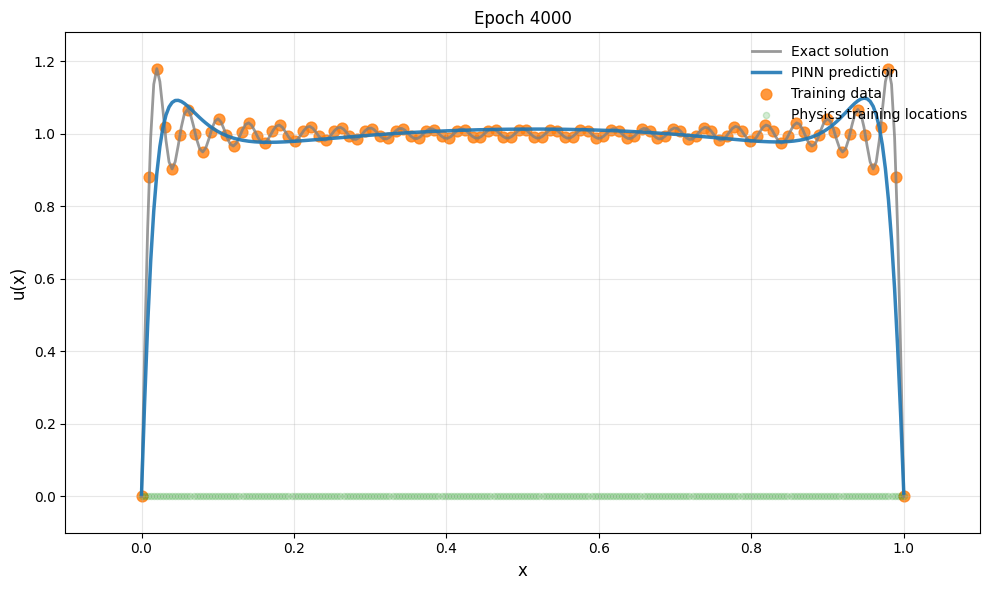

Training PINN:  90%|██████████████████████████████████████▍    | 4475/5000 [00:13<00:01, 413.10it/s]


Epoch 4500 | Data: 4.29e-03 | BC: 4.00e-05 | DE: 3.00e+03 | Total: 4.33e-03


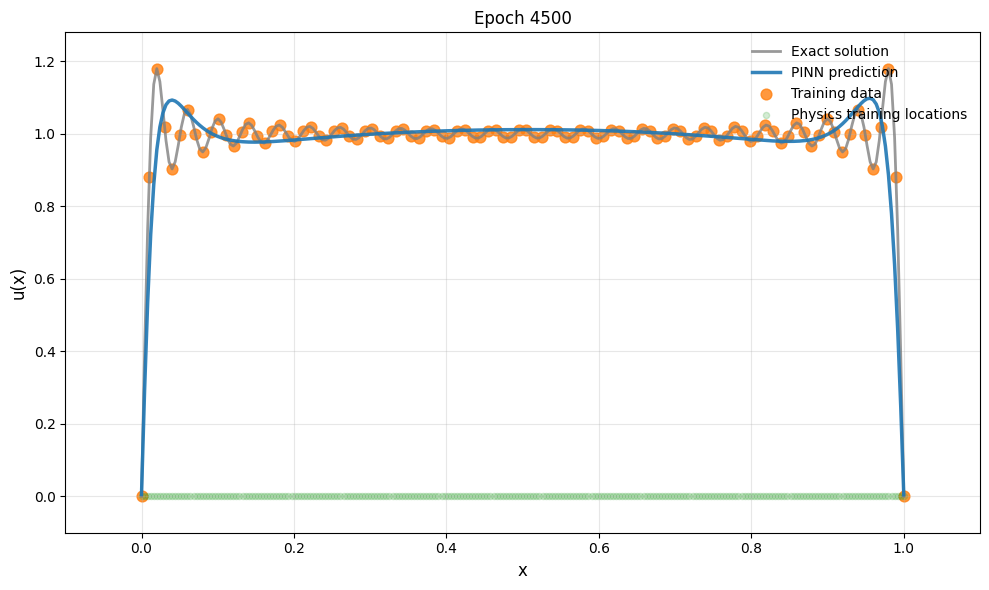

Training PINN: 100%|██████████████████████████████████████████▊| 4979/5000 [00:14<00:00, 411.27it/s]


Epoch 5000 | Data: 3.15e-03 | BC: 3.09e-05 | DE: 4.32e+03 | Total: 3.18e-03


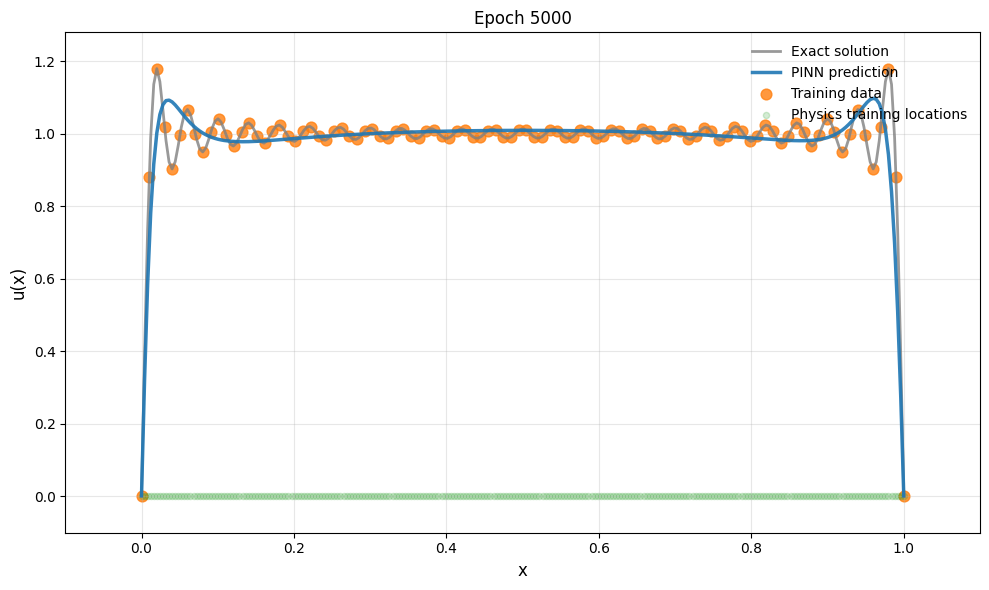

Training PINN: 100%|███████████████████████████████████████████| 5000/5000 [00:14<00:00, 340.26it/s]


In [153]:
from tqdm import trange
import os

# --- Parameters ---
L = 1
alpha = 0.1
nx = 250
epochs = 5000
lambda_data = 1.0
lambda_bc   = 1.0
lambda_DE   = 1e-10

# --- Ensure save directory exists ---
os.makedirs("Plots", exist_ok=True)

# --- Initial Condition ---
def f(x):
    return 1

# --- Data setup ---
x = torch.linspace(0, L, nx).view(-1, 1)
u = heateq(x, f)  # Exact / target solution
x_data = torch.linspace(0, L, 100).view(-1, 1)
u_data = heateq(x_data, f)

# --- Physics and boundary points ---
x_physics = torch.linspace(0, L, nx).view(-1, 1).requires_grad_(True)
x_bc = torch.tensor([[0.0], [L]], requires_grad=True)
u_bc = torch.tensor([[0.0], [0.0]])  # Dirichlet BC

# --- Model setup ---
model = FCN(1, 1, 64, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --- Plotting helper ---
def plot_result(x, y_exact, x_data, y_data, y_pred, x_phys=None, step=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Curves
    ax.plot(x, y_exact, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    ax.plot(x, y_pred, color="tab:blue", linewidth=2.5, alpha=0.9, label="PINN prediction")
    
    # Data points
    ax.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.8, label="Training data")
    
    # Physics points
    if x_phys is not None:
        ax.scatter(x_phys, np.zeros_like(x_phys), s=20, color="tab:green", alpha=0.2,
                   label="Physics training locations")
    
    ax.set_xlim(x.min()-0.1, x.max()+0.1)
    ax.set_ylim(y_exact.min() - 0.1, y_exact.max() + 0.1)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("u(x)", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", frameon=False)
    if step is not None:
        ax.set_title(f"Epoch {step}")
    plt.tight_layout()

    # --- Save and show ---
    plt.savefig(f"Plots/Epoch={step}.png", dpi=150)
    plt.show()
    plt.close(fig)

# --- Training loop ---
for i in trange(epochs, desc="Training PINN", ncols=100):
    optimizer.zero_grad()

    # --- Data loss ---
    u_pred_data = model(x_data)
    loss_data = torch.mean((u_pred_data - u_data) ** 2)
    
    # --- Physics loss ---
    u_phys = model(x_physics)
    du_dx = torch.autograd.grad(u_phys, x_physics, torch.ones_like(u_phys), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x_physics, torch.ones_like(du_dx), create_graph=True)[0]
    loss_DE = torch.mean((alpha * d2u_dx2) ** 2)
    
    # --- Boundary loss ---
    u_pred_bc = model(x_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc) ** 2)
    
    # --- Total loss ---
    loss = lambda_data * loss_data + lambda_bc * loss_bc + lambda_DE * loss_DE
    
    loss.backward()
    optimizer.step()
    
    # --- Logging ---
    if i == 0 or (i + 1) % 500 == 0:
        with torch.no_grad():
            u_pred = model(x).detach()
        print(f"\nEpoch {i+1:4d} | Data: {loss_data.item():.2e} | "
              f"BC: {loss_bc.item():.2e} | DE: {loss_DE.item():.2e} | Total: {loss.item():.2e}")
        
        plot_result(
            x.numpy(), u.numpy(), 
            x_data.numpy(), u_data.numpy(), 
            u_pred.numpy(), 
            x_phys=x_physics.detach().numpy(), 
            step=i + 1
        )

We can see our result more or less approximate the analytical solution! For more accuracy, we need more data points and also, higher epochs but of course, this is will lead to longer training time $\to$ **It's a trade-off!**